## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('E:/PTDLKD/Đồ án/dataset/CTLT.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
5,2019-01-09,32.790001,33.430000,32.730000,33.380001,33.380001,894400
6,2019-01-10,33.189999,33.970001,32.970001,33.880001,33.880001,748700
7,2019-01-11,33.830002,33.930000,33.570000,33.750000,33.750000,639800
8,2019-01-14,33.540001,33.689999,33.299999,33.590000,33.590000,779700
9,2019-01-15,33.720001,34.264999,33.520000,34.070000,34.070000,867700


## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show Dataframe
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...
2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500


## Describe Data

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1.119000e+03
mean,80.071323,81.264071,78.774144,80.051233,80.051233,1.451844e+06
std,30.077890,30.372008,29.679122,30.002664,30.002664,1.912181e+06
min,30.049999,30.660000,29.290001,29.840000,29.840000,2.197000e+05
25%,50.935000,51.800001,50.379999,51.329999,51.329999,7.148000e+05
50%,78.260002,79.400002,77.220001,78.550003,78.550003,1.004100e+06
75%,105.935001,107.257503,104.104999,106.025002,106.025002,1.475700e+06
max,142.639999,142.639999,140.779999,142.350006,142.350006,3.083880e+07


## Visualize Data

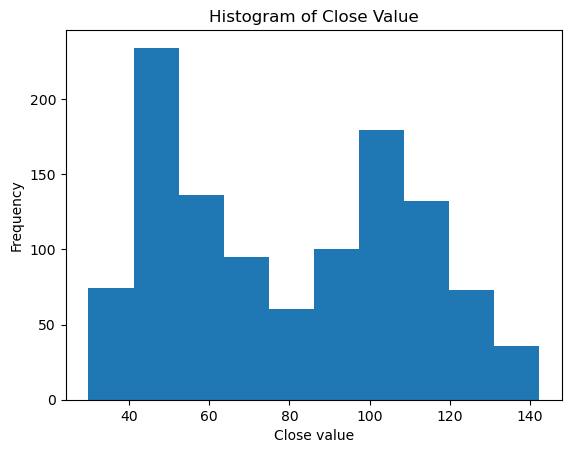

In [6]:
# Draw a histogram 
plt.hist(df['Close'])

# Set label and title
plt.xlabel('Close value')
plt.ylabel('Frequency')
plt.title('Histogram of Close Value')

# Display histogram
plt.show()

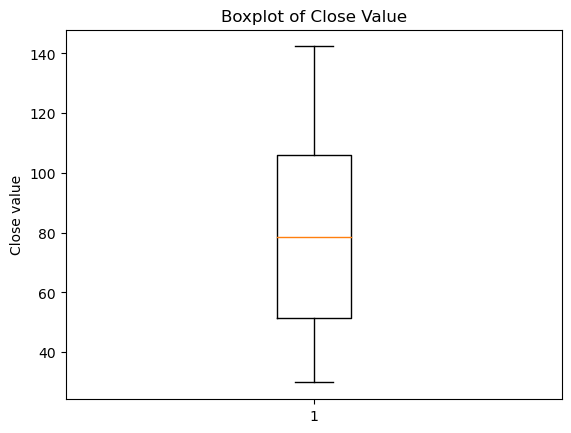

In [7]:
# Draw a boxplot
plt.boxplot(df.Close)

# Set label and title
plt.title("Boxplot of Close Value")
plt.ylabel("Close value")

# Display boxplot
plt.show()

## Scale Data

In [8]:
# Select 'Close' column
data = df['Close'].values

In [9]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [10]:
# Define the size of train, validation, test set
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

# Split the data into train, test and validation set
train_data = data_scaled[0 : train_size, :]
val_data = data_scaled[train_size : train_size + val_size, :]
test_data = data_scaled[train_size + val_size : len(data_scaled), :]

## Create and add data into X, y

In [11]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [12]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get lost data for test
val_last_windowsize = val_data[-sequence_length:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)
X_val, y_val = add_data(val_data, sequence_length)

## Build Model

In [13]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam',loss='mean_squared_error')

## Training Model

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=2)

Epoch 1/50
23/23 - 29s - loss: 0.0725 - val_loss: 0.0033 - 29s/epoch - 1s/step
Epoch 2/50
23/23 - 8s - loss: 0.0102 - val_loss: 0.0047 - 8s/epoch - 327ms/step
Epoch 3/50
23/23 - 8s - loss: 0.0074 - val_loss: 0.0026 - 8s/epoch - 369ms/step
Epoch 4/50
23/23 - 8s - loss: 0.0072 - val_loss: 0.0023 - 8s/epoch - 339ms/step
Epoch 5/50
23/23 - 8s - loss: 0.0075 - val_loss: 0.0022 - 8s/epoch - 327ms/step
Epoch 6/50
23/23 - 7s - loss: 0.0065 - val_loss: 0.0047 - 7s/epoch - 319ms/step
Epoch 7/50
23/23 - 7s - loss: 0.0060 - val_loss: 0.0026 - 7s/epoch - 300ms/step
Epoch 8/50
23/23 - 8s - loss: 0.0058 - val_loss: 0.0044 - 8s/epoch - 344ms/step
Epoch 9/50
23/23 - 7s - loss: 0.0060 - val_loss: 0.0022 - 7s/epoch - 323ms/step
Epoch 10/50
23/23 - 11s - loss: 0.0056 - val_loss: 0.0025 - 11s/epoch - 464ms/step
Epoch 11/50
23/23 - 8s - loss: 0.0060 - val_loss: 0.0025 - 8s/epoch - 367ms/step
Epoch 12/50
23/23 - 8s - loss: 0.0058 - val_loss: 0.0020 - 8s/epoch - 363ms/step
Epoch 13/50
23/23 - 8s - loss: 0.005

## Predict Close price in test and validation set

In [15]:
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

2/2 [==============================] - 0s 94ms/step


## Transform data back to the original

In [16]:
y_pred = scaler.inverse_transform(y_pred)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Calculate the error of the model

In [17]:
# The error in test set
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: ", test_mape)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAPE on Test set:  0.9957559538200007
RMSE on Test set:  68.2171584652703
MSLE on Test set:  15.085253818738506


## Predict Close price for 30 next days

In [18]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Predict Close price for 30 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_30_days = []

for i in range(30):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_30_days.append(next_day_pred[0][0])
    
    # Update information of the  next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 53ms/step


In [19]:
# Show the result of predict 30 next days 
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

[39.015594 39.240505 39.434875 39.58132  39.668907 39.69601  39.668873
 39.598473 39.497288 39.3766   39.245342 39.10951  38.972694 38.836494
 38.701397 38.5673   38.434044 38.301632 38.17017  38.039948 37.911556
 37.785137 37.661076 37.53956  37.42074  37.30465  37.191246 37.080418
 36.97191  36.865494]


## Model visualization

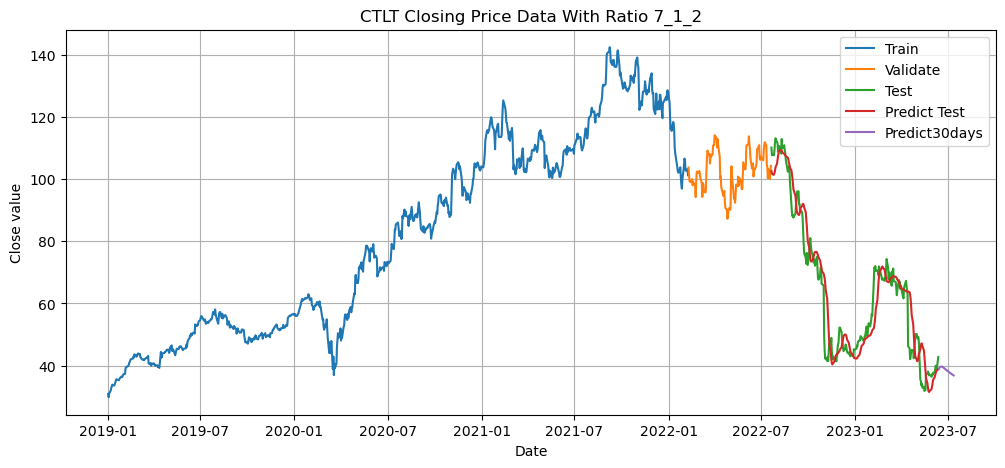

In [20]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Validation set
plt.plot(df[train_size : train_size + val_size].index, val_data)

# Test set
plt.plot(df[train_size + val_size: ].index, test_data)

# Predict in test set
plt.plot(df[train_size + val_size:].index, y_pred)

# Predict 30 next days
plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("CTLT Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RNN_712_CTLT.png')
plt.show()